In [3]:
# Import the necessary libraries:

# pandas: a powerful data manipulation library in Python
import pandas as pd

# numpy: a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices...
# along with a large collection of high-level mathematical functions to operate on these arrays.
import numpy as np

# matplotlib.pyplot: a Python-based plotting library used for creating static, animated
# and interactive visualizations in Python. Pyplot is a sub-library which emulates MATLAB's global plotting style.
import matplotlib.pyplot as plt

# fredapi: a Python interface to the Federal Reserve Economic Data (FRED) provided by the Federal Reserve Bank of St. Louis. 
# It works with both the FRED database and ALFRED database that contains point-in-time (as-revised) data.
from fredapi import Fred


Performing event analysis for GDP...


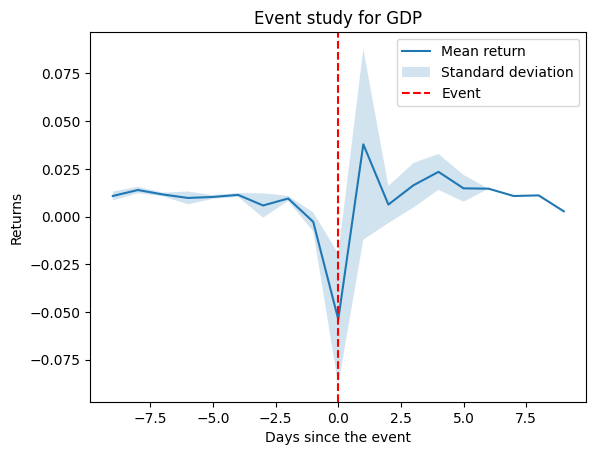


Performing event analysis for UNRATE...


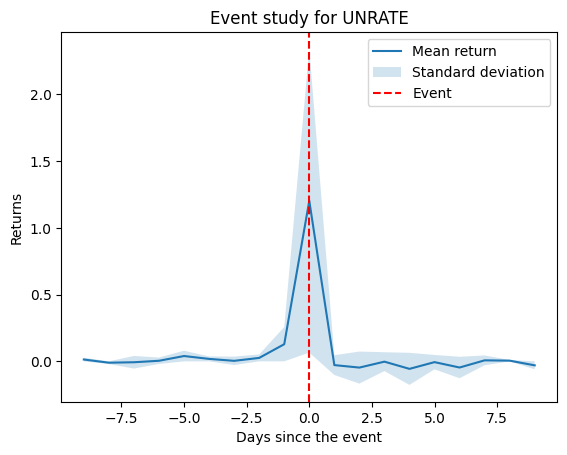


Performing event analysis for CPIAUCSL...


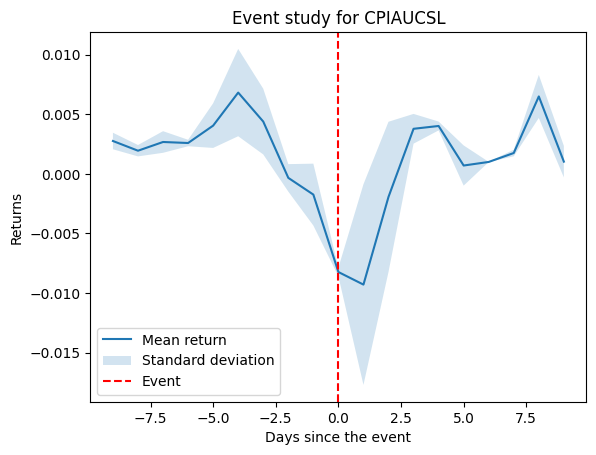

In [7]:
# Function to retrieve data for given economic indicators within a specified date range
def get_economic_data(fred, indicators, start_date, end_date):
    """
    Function to retrieve data for given economic indicators within a specified date range.
    :param fred: Fred API object.
    :param indicators: List of economic indicators.
    :param start_date: Start date for the time series.
    :param end_date: End date for the time series.
    :return: Dictionary containing time series data for each economic indicator.
    """
    data = {}

    for indicator in indicators:
        # Retrieve the time series data for each indicator and store in the data dictionary
        data[indicator] = fred.get_series(indicator, start_date, end_date)

    return data

# Function to perform an event study on economic indicators' historical data, given event dates and window lengths
def event_study(data, event_dates, pre_event_window, post_event_window, indicator):
    """
    Function to perform an event study on economic indicators' historical data, given event dates and window lengths.
    :param data: Time series data.
    :param event_dates: List of event dates.
    :param pre_event_window: Number of periods before the event date.
    :param post_event_window: Number of periods after the event date.
    :param indicator: Economic indicator being studied.
    :return: None.
    """

    # Initialize a list to store event windows
    event_windows = []

    # Iterate through each event date
    for event_date in event_dates:
        # Find the closest available data point before the event_date
        pre_event_date = data.loc[:event_date].last_valid_index()

        if pre_event_date is None:
            print(f"No valid data before the event date: {event_date}")
            continue

        # Find the index of the pre-event date in the data
        pre_event_index = data.index.get_loc(pre_event_date)

        # Calculate the start and end indices for the pre-event and post-event windows
        pre_event_start_index = max(0, pre_event_index - pre_event_window + 1)
        post_event_end_index = min(len(data) - 1, pre_event_index + post_event_window)

        # Extract the data within the event window
        event_window = data.iloc[pre_event_start_index:post_event_end_index + 1]

        # Calculate daily returns within the event window
        event_window['Returns'] = event_window.pct_change()

        # Append the event window returns (excluding the first NaN value) to the list of event windows
        event_windows.append(event_window['Returns'].dropna().values)

    # Calculate the length of the longest event window
    max_length = max([len(window) for window in event_windows])

    # Pad event windows with NaN values to have the same length
    event_windows_padded = [np.pad(window, (0, max_length - len(window)), constant_values=np.nan) for window in event_windows]

    # Convert the list of padded event windows to a 2D NumPy array
    event_windows_array = np.array(event_windows_padded)

    # Calculate the mean and standard deviation of returns across all event windows
    mean_returns = np.nanmean(event_windows_array, axis=0)
    std_returns = np.nanstd(event_windows_array, axis=0)

    # Create a timeline centered around the event (x=0)
    x = np.arange(-pre_event_window + 1, len(mean_returns) - pre_event_window + 1)


    # Plot the mean returns and the standard deviation bands around the mean
    # Here, mean return of the event windows is plotted against the days since the event
    plt.plot(x, mean_returns, label='Mean return')
    # Fill between the mean return and standard deviation values to create a shaded area representing the standard deviation
    plt.fill_between(x, mean_returns - std_returns, mean_returns + std_returns, alpha=0.2, label='Standard deviation')

    # Add a vertical line at x=0 to represent the event date
    plt.axvline(0, color='red', linestyle='--', label='Event')
    plt.xlabel('Days since the event')
    plt.ylabel('Returns')
    plt.title(f'Event study for {indicator}')
    plt.legend()

    # Save the figure and display it
    plt.savefig(f'{indicator}_event_study.png')
    plt.show()

# Define your API key for FRED
api_key = 'your own api key' # please replace with your own API key
fred = Fred(api_key=api_key)

# Set the pre- and post-event window lengths
pre_event_window = 10
post_event_window = 10

# Define the list of economic indicators and event dates
indicators = ['GDP', 'UNRATE', 'CPIAUCSL']
event_dates = [pd.to_datetime('2020-03-11'), pd.to_datetime('2008-09-15')]

# Extract the historical data for the given economic indicators
# Here, we're using our previously defined function to retrieve historical data for the specified indicators
historical_data = get_economic_data(fred, indicators, '2000-01-01', '2021-09-01')

# Perform the event study using the historical data and event dates
for indicator in indicators:
    print(f"\nPerforming event analysis for {indicator}...")

    # Drop missing values from the data
    data = historical_data[indicator].dropna()

    # Run the event study
    event_study(data, event_dates, pre_event_window, post_event_window, indicator)